<a href="https://colab.research.google.com/github/DavidGreigQC/sarveillance/blob/main/sarveillance/sar-data/SARveillance_Tanjim_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SARveillance 3.1 - Tanjim Chowdhury (Data Analysis)**

**Problem Statement:** Detecting and classifying oil spills in coastal and inland waters is complex due to various factors. This project aims to integrate Synthetic Aperture Radius (SAR) imagery, Automatic Identification System (AIS) data, and environmental variables to accurately analyze oil spills in the Chesapeake Bay.

# **Chesapeak Bay: Oil vs Water SAR Dataset (`sar_data`)**

**Goal:** Exploratory data analysis and visualization

In [39]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import h5py
import plotly.express as px
import missingno
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Importing the CSV file
from google.colab import drive
drive.mount('/content/drive')
file_id = '1LResEO0ZGbLKolU-2drpALtjO-MUpjB7'
download_url = f'https://drive.google.com/uc?id={file_id}'
sar_data = pd.read_csv(download_url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Prevewing the dataset
sar_data.head()

,system:index,VH,VH_VV_ratio,VV,angle,oil_candidate,orbit_direction,.geo
0,1_9,-26.101991,0.894205,-29.190160,36.032364,1,1,"{""type"":""Point"",""coordinates"":[-75.49253512625..."
1,1_21,-26.815224,1.183961,-22.648741,39.813244,1,1,"{""type"":""Point"",""coordinates"":[-75.13799456813..."
2,1_28,-26.422291,1.155114,-22.874185,32.658546,1,1,"{""type"":""Point"",""coordinates"":[-76.06084721612..."
3,1_69,-27.163505,1.136072,-23.910019,37.820728,1,1,"{""type"":""Point"",""coordinates"":[-75.26614615061..."
4,1_80,-28.898875,1.272032,-22.718672,35.698414,1,1,"{""type"":""Point"",""coordinates"":[-75.54055122714..."


**Column by Column Explanation**
*   `system:index`: Unique identifier for each data point or pixel (e.g., "1_9", "1_21"
*   `VH`: Backscatter intensity in **Vertical transmit, Horizontal receive** polarization (in dB)
*   `VH_VV_ratio`: Ratio of VH to VV backscatter values, which is used to highlight surface texture or material differences
*   `VV`: Backscatter intensity in **Vertical transmit, Vertical receive** polarization (in dB)
*   `angle`: **Incidence angle** of the radar beam which affects how the surface reflects the signal
*   `oil_candidate`: Binary flag (likely `1` for yes, `0` for no) indicating whether the pixel is a potential **oil spill candidate**
*   `orbit_direction`: Satellite pass direction, probably `1` for ascending or descending orbit
*   `.geo`: GeoJSON-style coordinate object which contains the **longitude and latitude** of the pixel location

\
**What Is VH/VV Ratio?**

The VH/VV ratio compares the backscatter intensity of two polarization channels:
- **VH:** Vertical transmit, Horizontal receive
- **VV:** Vertical transmit, Vertical receive
This ratio highlights differences in scattering behavior:
- **Low ratio →** smoother surfaces (e.g., calm water)
- **High ratio →** rougher or more complex surfaces (e.g., vegetation, urban areas)


In [41]:
# Checking is there any null values or not
print(sar_data.isna().sum())

# There is no null values, no data cleaning needed

system:index       0
VH                 0
VH_VV_ratio        0
VV                 0
angle              0
oil_candidate      0
orbit_direction    0
.geo               0
dtype: int64


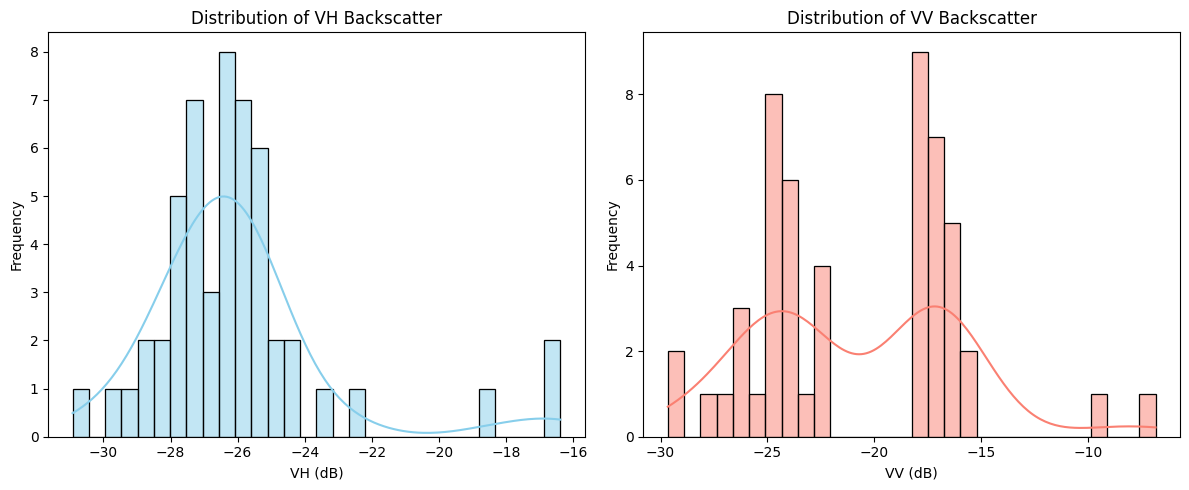

In [42]:
# Distribution of VH and VV Backscatter

plt.figure(figsize=(12, 5))

# VH Histogram
plt.subplot(1, 2, 1)
sns.histplot(sar_data['VH'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of VH Backscatter')
plt.xlabel('VH (dB)')
plt.ylabel('Frequency')

# VV Histogram
plt.subplot(1, 2, 2)
sns.histplot(sar_data['VV'], bins=30, kde=True, color='salmon')
plt.title('Distribution of VV Backscatter')
plt.xlabel('VV (dB)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

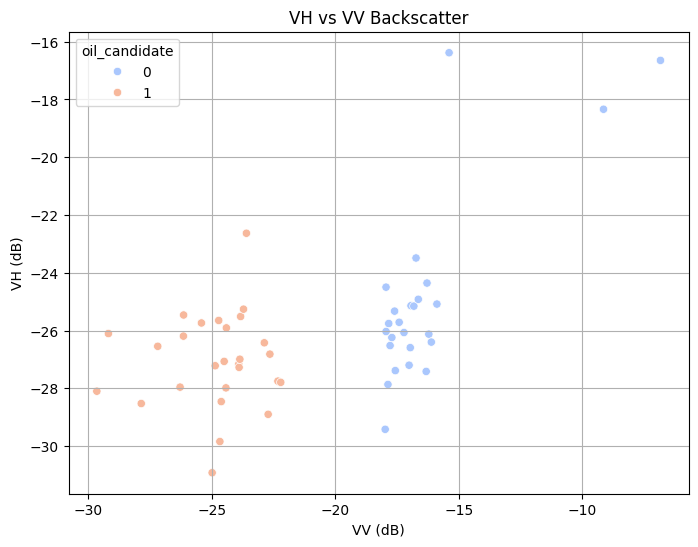

In [43]:
# VH vs VV Backscatter
plt.figure(figsize=(8, 6))
sns.scatterplot(x='VV', y='VH', data=sar_data, hue='oil_candidate', palette='coolwarm')
plt.title('VH vs VV Backscatter')
plt.xlabel('VV (dB)')
plt.ylabel('VH (dB)')
plt.grid(True)
plt.show()

In [44]:
# Preparing data for visualization

import json

# Filter only oil candidate points
oil_points = sar_data[sar_data['oil_candidate'] == 1]

# Extract coordinates from GeoJSON-style strings
def extract_coords(geo_str):
    geo_json = json.loads(geo_str)
    return geo_json['coordinates'][1], geo_json['coordinates'][0]  # (lat, lon)

oil_points['lat_lon'] = oil_points['.geo'].apply(extract_coords)

/tmp/ipython-input-1790600436.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil_points['lat_lon'] = oil_points['.geo'].apply(extract_coords)


In [45]:
# Oil Spill Candidate Spatial Distribution

# Center map on the first oil candidate
start_lat, start_lon = oil_points['lat_lon'].iloc[0]

m = folium.Map(location=[start_lat, start_lon], zoom_start=10)

# Add markers
for lat, lon in oil_points['lat_lon']:
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=f"VH: {round(sar_data.loc[(sar_data['.geo'].apply(extract_coords) == (lat, lon))]['VH'].values[0], 2)} dB"
    ).add_to(m)

m

/tmp/ipython-input-1580882277.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='oil_candidate', y='VH_VV_ratio', data=sar_data, palette='Set2')


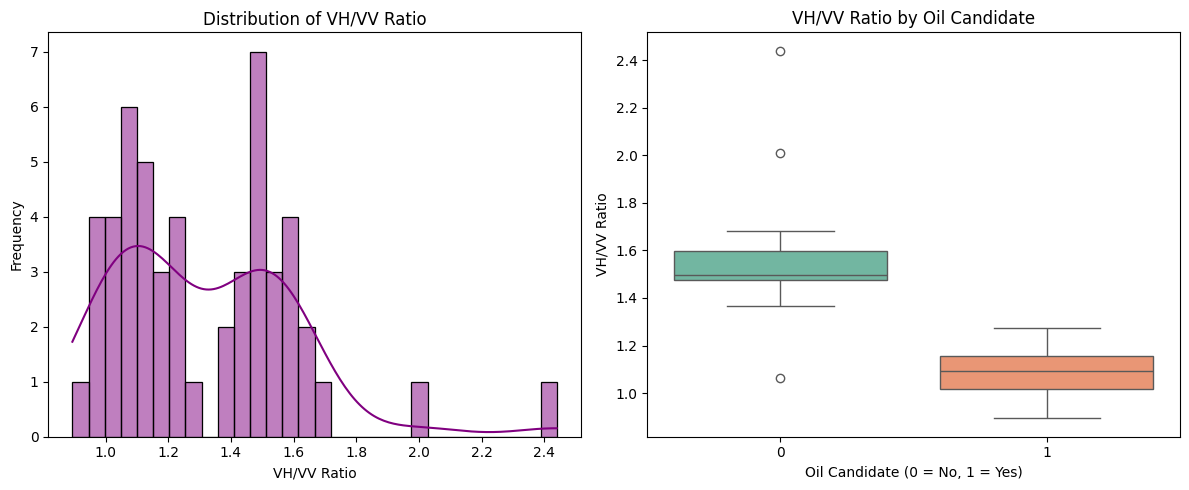

In [46]:
# Distribution VH/VV Ratio and VH/VV Ratio by Oil Candidate

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(sar_data['VH_VV_ratio'], bins=30, kde=True, color='purple')
plt.title('Distribution of VH/VV Ratio')
plt.xlabel('VH/VV Ratio')
plt.ylabel('Frequency')

# Boxplot by oil_candidate
plt.subplot(1, 2, 2)
sns.boxplot(x='oil_candidate', y='VH_VV_ratio', data=sar_data, palette='Set2')
plt.title('VH/VV Ratio by Oil Candidate')
plt.xlabel('Oil Candidate (0 = No, 1 = Yes)')
plt.ylabel('VH/VV Ratio')

plt.tight_layout()
plt.show()

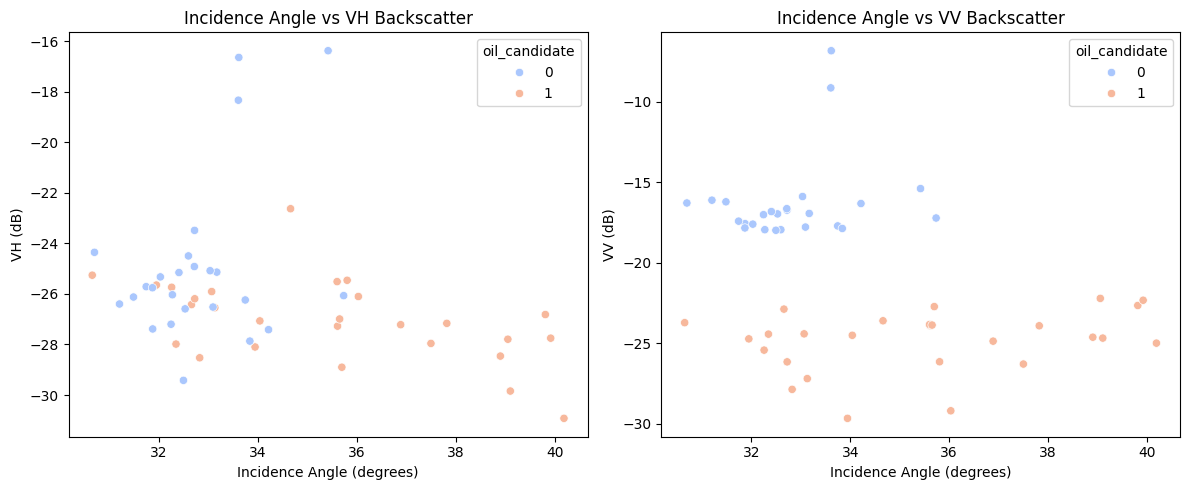

In [47]:
# Incidence Angle vs VH Backscatter vs VV Backscatter

plt.figure(figsize=(12, 5))

# Angle vs VH
plt.subplot(1, 2, 1)
sns.scatterplot(x='angle', y='VH', data=sar_data, hue='oil_candidate', palette='coolwarm')
plt.title('Incidence Angle vs VH Backscatter')
plt.xlabel('Incidence Angle (degrees)')
plt.ylabel('VH (dB)')

# Angle vs VV
plt.subplot(1, 2, 2)
sns.scatterplot(x='angle', y='VV', data=sar_data, hue='oil_candidate', palette='coolwarm')
plt.title('Incidence Angle vs VV Backscatter')
plt.xlabel('Incidence Angle (degrees)')
plt.ylabel('VV (dB)')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2629071095.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='oil_candidate', y='angle', data=sar_data, palette='Set3')


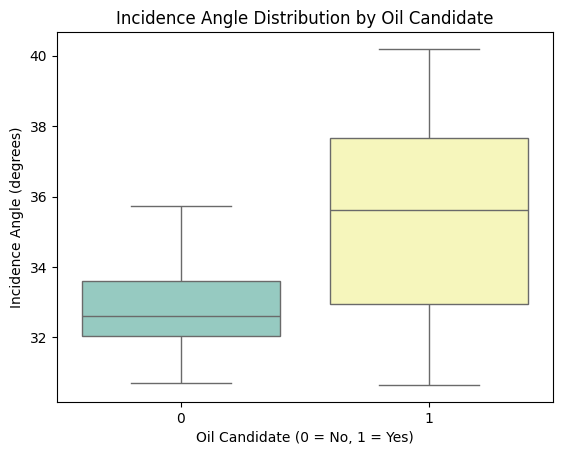

In [48]:
# Incidence Angle Distribution by Oil Candidate

sns.boxplot(x='oil_candidate', y='angle', data=sar_data, palette='Set3')
plt.title('Incidence Angle Distribution by Oil Candidate')
plt.xlabel('Oil Candidate (0 = No, 1 = Yes)')
plt.ylabel('Incidence Angle (degrees)')
plt.show()

# **NASA POWER API (`nasa_power`)**
**Goal:**
- Add context to SAR-detected oil spills.
- Analyze correlations between environmental variables and oil presence or spread.
- Support predictive modeling.

In [49]:
# EDA for NASA POWER Dataset

import requests

# Chesapeake Bay approximate coordinates
lat, lon = 37.5, -76.5

# NASA POWER API URL
url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=T2M,PRECTOTCORR&community=RE&longitude={lon}&latitude={lat}&start=20240101&end=20240131&format=JSON"

response = requests.get(url).json()

# Extracting data
data = response['properties']['parameter']
nasa_power = pd.DataFrame(data)

In [50]:
# Prevewing the dataset
print(nasa_power.head())

           T2M  PRECTOTCORR
20240101  5.31         0.33
20240102  4.34         0.31
20240103  4.59         0.00
20240104  5.16         0.31
20240105  2.04         0.00


**Column by Column Explanation**
* Index (`20240101`) → Date (YYYYMMDD).
* T2M → Average temperature at 2 meters above ground (°C).
* PRECTOTCORR → Total precipitation (mm/day).

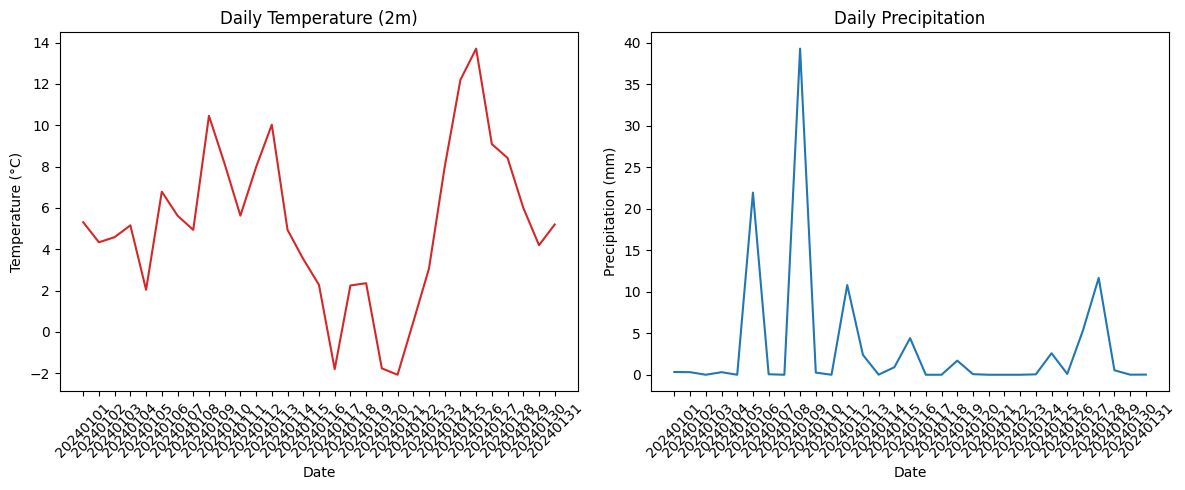

In [51]:
# Temperature vs Precipitation

nasa_power.corr()

plt.figure(figsize=(12, 5))

# Date vs Temperature (Line Chart)
plt.subplot(1, 2, 1)
sns.lineplot(x=nasa_power.index, y='T2M', data=nasa_power, color='tab:red')
plt.title('Daily Temperature (2m)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)

# Date vs Precipitation (Line Chart)
plt.subplot(1, 2, 2)
sns.lineplot(x=nasa_power.index, y='PRECTOTCORR', data=nasa_power, color='tab:blue')
plt.title('Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

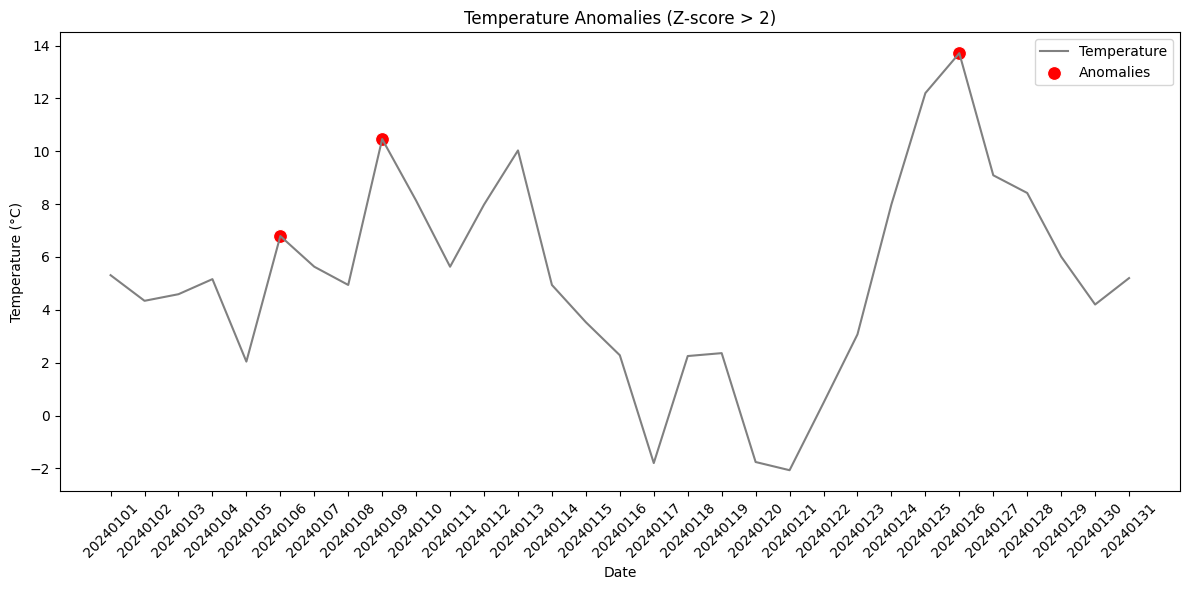

In [52]:
# Z-score based anomaly detection

from scipy.stats import zscore

# Compute Z-scores for each variable
nasa_power['T2M_z'] = zscore(nasa_power['T2M'])
nasa_power['PRECTOTCORR_z'] = zscore(nasa_power['PRECTOTCORR'])

# Define threshold (e.g., |z| > 2 is considered anomalous)
threshold = 2
anomalies = nasa_power[(abs(nasa_power['T2M_z']) > threshold) | (abs(nasa_power['PRECTOTCORR_z']) > threshold)]

# Visualizing anomalies
plt.figure(figsize=(12, 6))

# Plot temperature with anomalies
sns.lineplot(x=nasa_power.index, y='T2M', data=nasa_power, label='Temperature', color='gray')
sns.scatterplot(x=anomalies.index, y=anomalies['T2M'], color='red', label='Anomalies', s=100)

plt.title('Temperature Anomalies (Z-score > 2)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

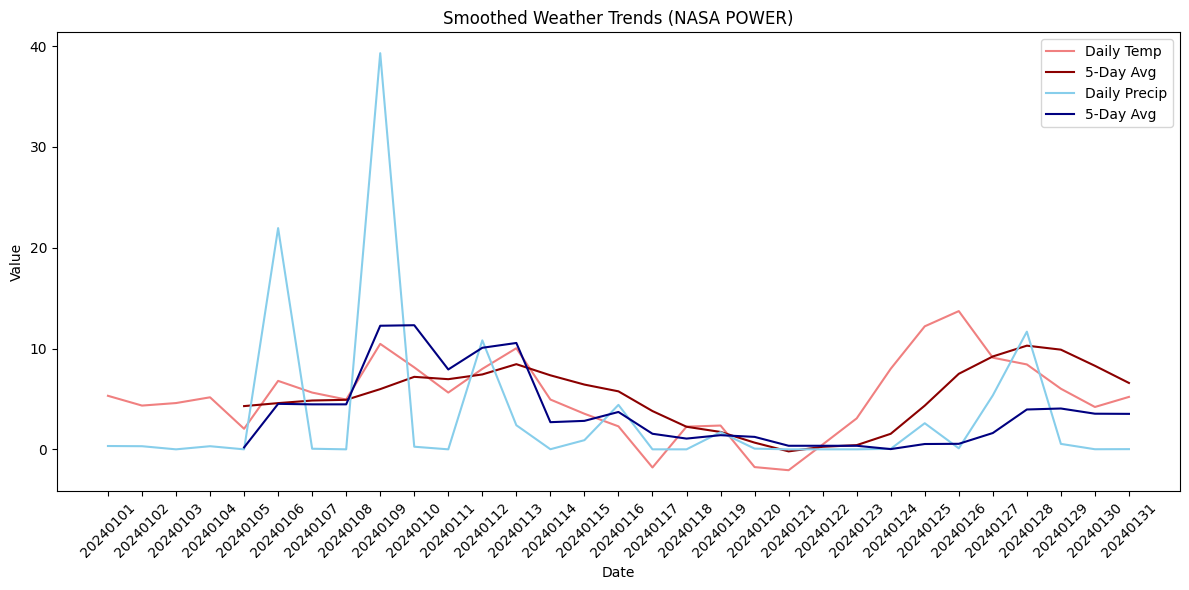

In [53]:
# Rolling Averages and Smoothing

# 5-day rolling mean
nasa_power['T2M_rolling'] = nasa_power['T2M'].rolling(window=5).mean()
nasa_power['PRECTOTCORR_rolling'] = nasa_power['PRECTOTCORR'].rolling(window=5).mean()

# Visualizing smoothed trends

plt.figure(figsize=(12, 6))

# Temperature
sns.lineplot(x=nasa_power.index, y='T2M', data=nasa_power, label='Daily Temp', color='lightcoral')
sns.lineplot(x=nasa_power.index, y='T2M_rolling', data=nasa_power, label='5-Day Avg', color='darkred')

# Precipitation
sns.lineplot(x=nasa_power.index, y='PRECTOTCORR', data=nasa_power, label='Daily Precip', color='skyblue')
sns.lineplot(x=nasa_power.index, y='PRECTOTCORR_rolling', data=nasa_power, label='5-Day Avg', color='navy')

plt.title('Smoothed Weather Trends (NASA POWER)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

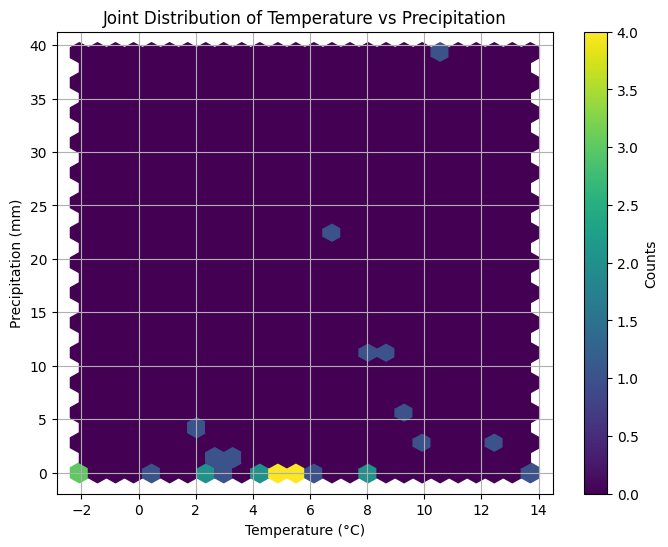

In [54]:
# Hexbin Plot (Density Based)

plt.figure(figsize=(8, 6))
plt.hexbin(x=nasa_power['T2M'], y=nasa_power['PRECTOTCORR'], gridsize=25, cmap='viridis')
plt.colorbar(label='Counts')
plt.title('Joint Distribution of Temperature vs Precipitation')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()

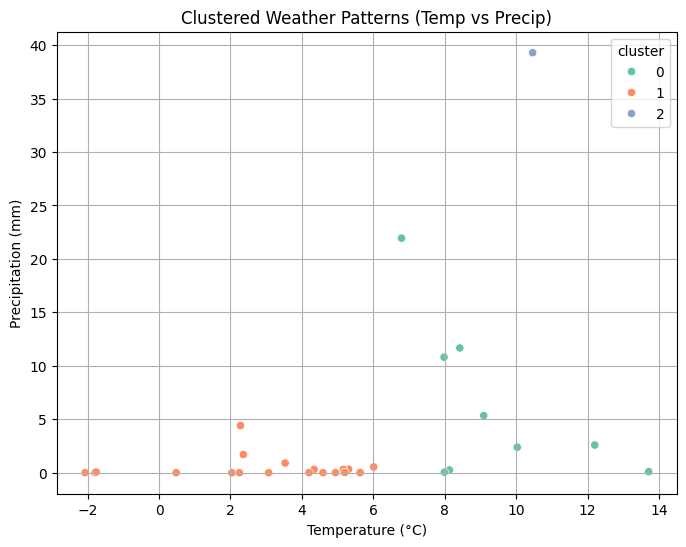

[[ 9.37111111  6.12888889]
 [ 3.15857143  0.41333333]
 [10.46       39.29      ]]


In [55]:
# K-Means Clustering on Temp vs Precip

# Preparing the data

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features and scale them
X = nasa_power[['T2M', 'PRECTOTCORR']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying K-Means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
nasa_power['cluster'] = kmeans.fit_predict(X_scaled)

# Visulaizing the clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(x='T2M', y='PRECTOTCORR', hue='cluster', data=nasa_power, palette='Set2')
plt.title('Clustered Weather Patterns (Temp vs Precip)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.show()
print(scaler.inverse_transform(kmeans.cluster_centers_))

- Cluster 1 is the baseline: cold, dry, and frequent.
- Cluster 0 adds nuance: mild temps with light rain—great for detecting shifts or transitions.
- Cluster 2 is the outlier: warm and drenched, possibly linked to extreme weather or climate anomalies.

We identified three distinct weather regimes in Chesapeake Bay’s January climate. Most days are cold and dry, but occasional warm-wet events hint at storm systems or climate variability. These clusters help us understand surface conditions and could inform SAR-based anomaly detection.

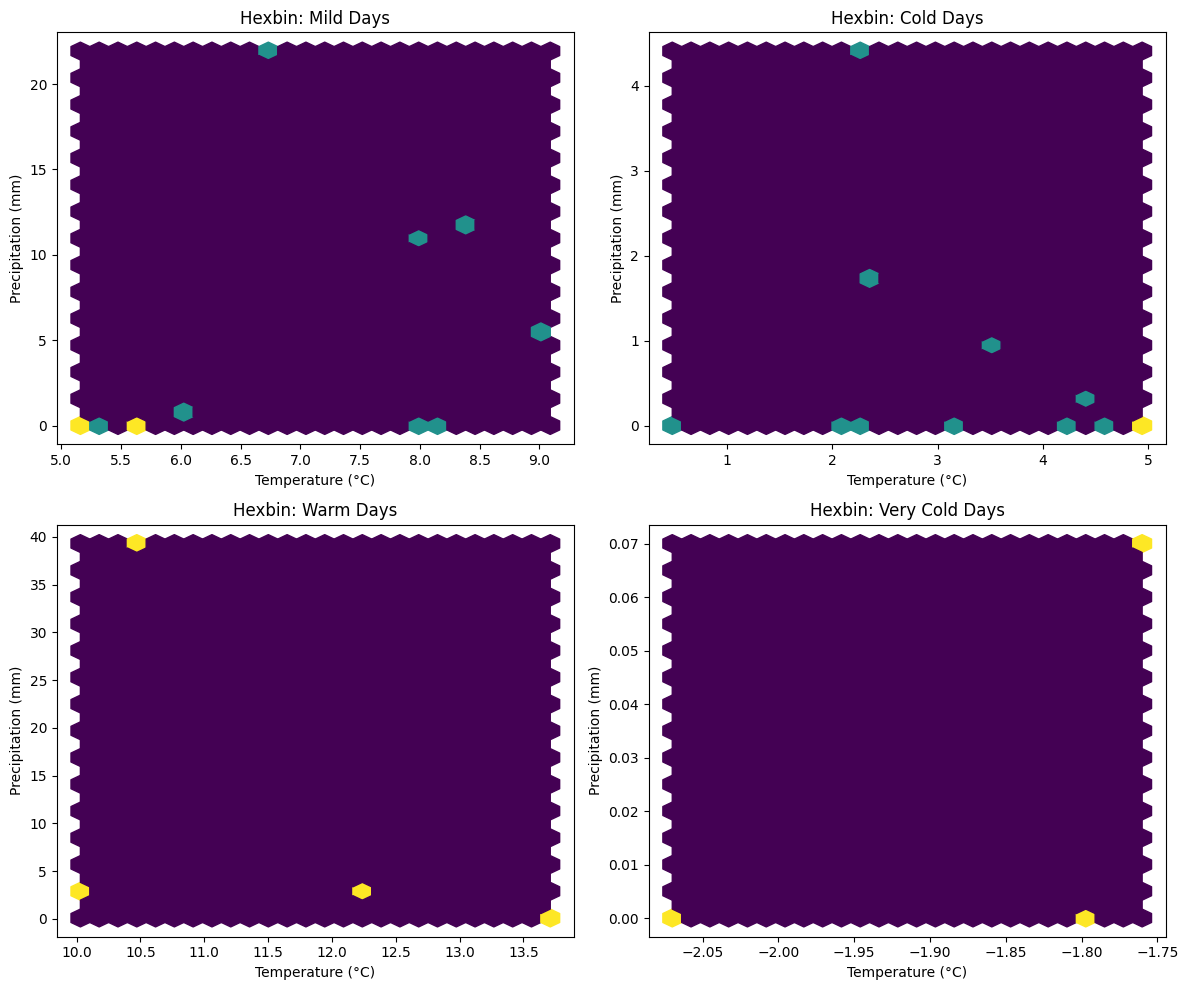

In [56]:
# Conditional Analysis

# Creating temp bands
nasa_power['temp_band'] = pd.cut(nasa_power['T2M'], bins=[-5, 0, 5, 10, 15], labels=['Very Cold', 'Cold', 'Mild', 'Warm'])

# Plotting hexbin for each band
bands = nasa_power['temp_band'].unique()
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, band in enumerate(bands):
    ax = axs[i//2, i%2]
    subset = nasa_power[nasa_power['temp_band'] == band]
    ax.hexbin(subset['T2M'], subset['PRECTOTCORR'], gridsize=25, cmap='viridis')
    ax.set_title(f'Hexbin: {band} Days')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Precipitation (mm)')

plt.tight_layout()
plt.show()

| Category         | Temp Range (°C) | Precipitation Pattern | Interpretation                                                  |
|------------------|-----------------|-----------------------|----------------------------------------------------------------|
| Very Cold Days   | ~ -2 to 0       | Near-zero             | Classic winter calm → ideal for SAR-based oil detection due to low surface roughness |
| Cold Days        | ~ 3 to 5        | Mostly dry, light rain| Transitional zone → watch for subtle SAR anomalies              |
| Mild Days        | ~ 5 to 9        | More variability      | Potential for surface changes → could correlate with SAR noise or false positives |
| Warm Days        | ~ 11 to 13.5    | Mostly dry            | Rare but interesting → check for outliers in SAR backscatter or oil candidate flags |

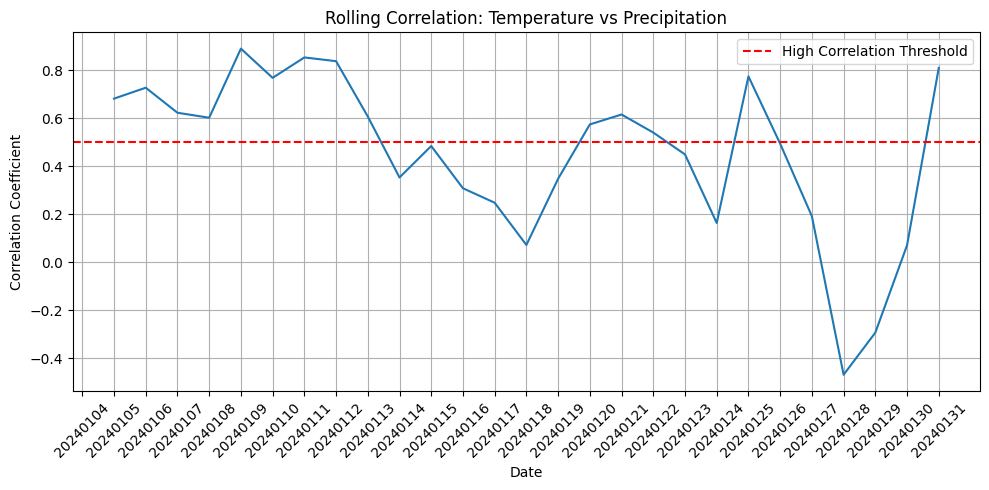

In [57]:
# Correlation Over Time

# Rolling Correlation (5-day window)

# Calculate rolling correlation
nasa_power['rolling_corr'] = nasa_power['T2M'].rolling(window=5).corr(nasa_power['PRECTOTCORR'])

# Plot with explicit data reference
plt.figure(figsize=(10, 5))
sns.lineplot(x=nasa_power.index, y=nasa_power['rolling_corr'])
plt.title('Rolling Correlation: Temperature vs Precipitation')
plt.xlabel('Date')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.axhline(0.5, color='red', linestyle='--', label='High Correlation Threshold')
plt.legend()
plt.show()

This plot shows:
- Spikes above 0.5 suggest periods where temperature and precipitation rise together—possibly storm events or humid transitions.
- Negative dips might indicate cold, dry spells—ideal for SAR clarity and oil slick detection.
- Flat zones near zero could be ambiguous weather—great for testing model sensitivity.

| Correlation Phase     | Weather Interpretation        | SAR Detection Implication                          |
|-----------------------|-------------------------------|----------------------------------------------------|
| **High Positive (>0.5)** | Warm + wet coupling (stormy)   | Surface clutter likely, SAR anomalies may be noisy  |
| **Neutral (~0)**        | Weak or no relationship         | Mixed conditions, good for testing model robustness |
| **Negative (<0)**       | Cold + dry decoupling           | Ideal for oil detection, calm surface, low noise    |


> Most January days in Chesapeake Bay are cold and dry and it's perfect for SAR-based oil spill detection. But when temperature and precipitation spike, surface conditions shift.

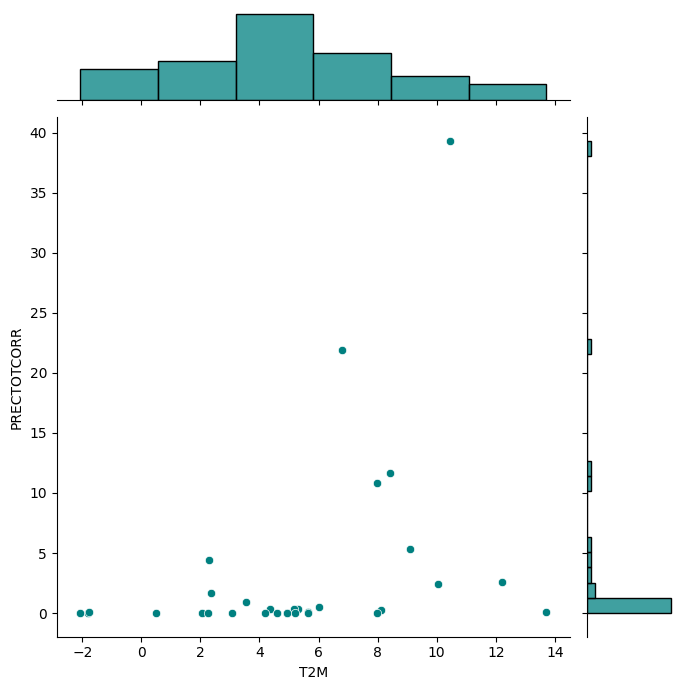

In [58]:
# Seaborn Jointplot (Scatter + Marginals)
sns.jointplot(x='T2M', y='PRECTOTCORR', data=nasa_power, kind='scatter', color='teal', height=7)

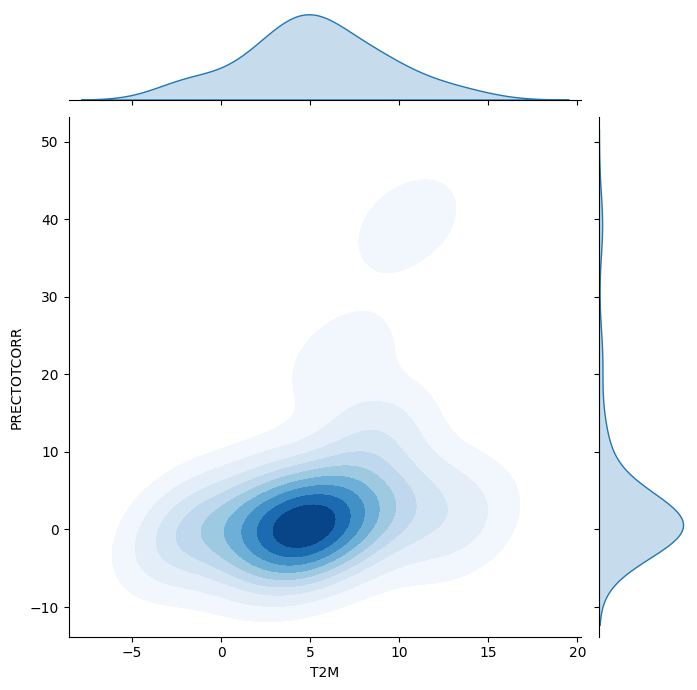

In [59]:
# Seaborn KDE Jointplot (Smoothed Density)
sns.jointplot(x='T2M', y='PRECTOTCORR', data=nasa_power, kind='kde', fill=True, cmap='Blues', height=7)

# **Chesapeak Bay SAR Data (`sar_data_2`)**

**EDA Goal**

- How SAR features (VH, VV, VH/VV ratio) change with environmental factors (wind, precipitation, temperature).
- Whether “oil_candidate” = 1 correlates with certain conditions (calm sea, low wind, low backscatter).
- Temporal and spatial patterns (daily, seasonal, geographic clusters).
- Run multiple correlation methods (Pearson, Spearman, Kendall).
- Automatically pick all numeric columns from your dataset.\
- Integrate NASA POWER environmental data (temperature, precipitation, etc.) with your SAR dataset — to improve correlations.

In [60]:
# Importing the new dataset
from google.colab import drive
drive.mount('/content/drive')

file_id = '13zO3jKyPlFgLTeoWl5-CfSO7SpYhG3oB'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

sar_data_2 = pd.read_csv(download_url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Preview the dataset
sar_data_2.head()

,system:index,VH,VH_VV_ratio,VV,angle,date,dewpoint_temperature_2m,latitude,longitude,oil_candidate,...,orbit_type,surface_net_solar_radiation,surface_pressure,temperature_2m,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,wind_direction_degrees,wind_speed_10m,.geo
0,0_1_33,-55.104848,1.223977,-45.021158,45.592400,2015-03-10,273.944037,39.368536,-76.010592,1,...,ASC,1.669555e+06,102131.101562,276.243813,0.000543,-1.100690,0.553357,-63.309665,1.231959,"{""type"":""Point"",""coordinates"":[-76.01059248597..."
1,0_1_139,-28.629801,1.050769,-27.246532,44.504768,2015-03-10,274.696804,39.033275,-76.188480,1,...,ASC,1.725879e+06,102296.893229,277.090005,0.000678,-1.510887,1.582450,-43.674721,2.187905,"{""type"":""Point"",""coordinates"":[-76.18847968650..."
2,0_1_239,-29.586230,1.173392,-25.214267,44.567307,2015-03-10,278.583035,37.959352,-75.946199,1,...,ASC,3.078623e+06,102394.184896,281.127846,0.000015,-1.579979,2.334810,-34.086427,2.819162,"{""type"":""Point"",""coordinates"":[-75.94619901488..."
3,0_1_250,-27.102570,1.093680,-24.781089,45.115185,2015-03-10,278.489203,37.712585,-75.779616,1,...,ASC,3.218869e+06,102304.476562,280.339354,0.000002,-1.506045,2.814994,-28.147147,3.192548,"{""type"":""Point"",""coordinates"":[-75.77961592134..."
4,0_1_290,-27.075435,1.123007,-24.109770,43.942677,2015-03-10,276.368272,38.733922,-76.248427,1,...,ASC,1.981721e+06,102305.226562,279.038410,0.000290,-1.399315,1.830172,-37.400849,2.303825,"{""type"":""Point"",""coordinates"":[-76.24842717678..."


**Column by Column Explanation**


| Column                                               | Meaning                                                                       | Type        |
| ---------------------------------------------------- | ----------------------------------------------------------------------------- | ----------- |
| `system:index`                                       | Unique ID per observation                                                     | string      |
| `VH`, `VV`                                           | SAR backscatter (vertical–horizontal and vertical–vertical polarizations, dB) | float       |
| `VH_VV_ratio`                                        | Ratio between VH and VV (often used to detect oil slicks)                     | float       |
| `angle`                                              | Incidence angle (°)                                                           | float       |
| `date`                                               | Observation date                                                              | datetime    |
| `dewpoint_temperature_2m`, `temperature_2m`          | Atmospheric variables (Kelvin)                                                | float       |
| `surface_net_solar_radiation`                        | Solar energy (J/m²)                                                           | float       |
| `surface_pressure`                                   | Air pressure (Pa)                                                             | float       |
| `total_precipitation`                                | Rainfall (m)                                                                  | float       |
| `u_component_of_wind_10m`, `v_component_of_wind_10m` | Wind vector components                                                        | float       |
| `wind_direction_degrees`, `wind_speed_10m`           | Derived from U/V                                                              | float       |
| `latitude`, `longitude`                              | Location                                                                      | float       |
| `orbit_direction`, `orbit_type`                      | Satellite orbit metadata                                                      | categorical |
| `oil_candidate`                                      | **Label** — 1 = possible oil spill, 0 = normal sea                            | int         |
| `.geo`                                               | GeoJSON point                                                                 | geometry    |

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9381 entries, 0 to 9380
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   system:index                 9381 non-null   object 
 1   VH                           9381 non-null   float64
 2   VH_VV_ratio                  9381 non-null   float64
 3   VV                           9381 non-null   float64
 4   angle                        9381 non-null   float64
 5   date                         9381 non-null   object 
 6   dewpoint_temperature_2m      9381 non-null   float64
 7   latitude                     9381 non-null   float64
 8   longitude                    9381 non-null   float64
 9   oil_candidate                9381 non-null   int64  
 10  orbit_direction              9381 non-null   int64  
 11  orbit_type                   9381 non-null   object 
 12  surface_net_solar_radiation  9381 non-null   float64
 13  surface_pressure  

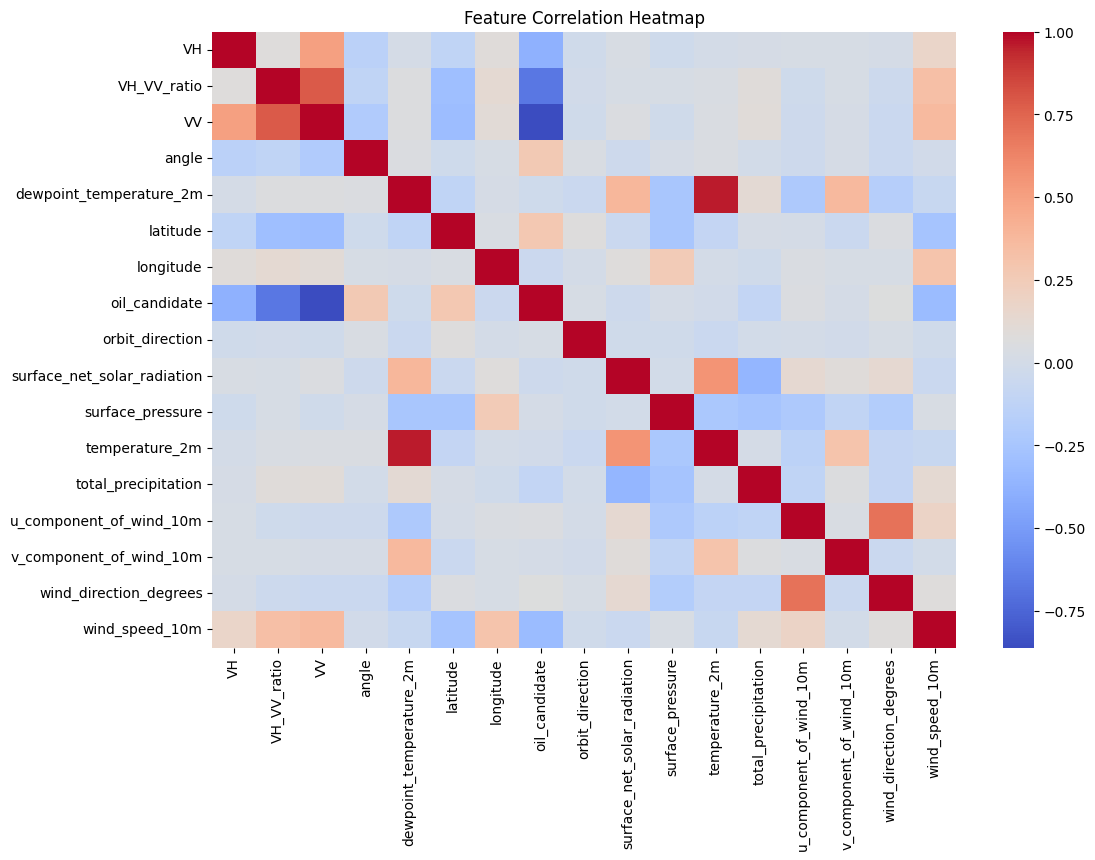

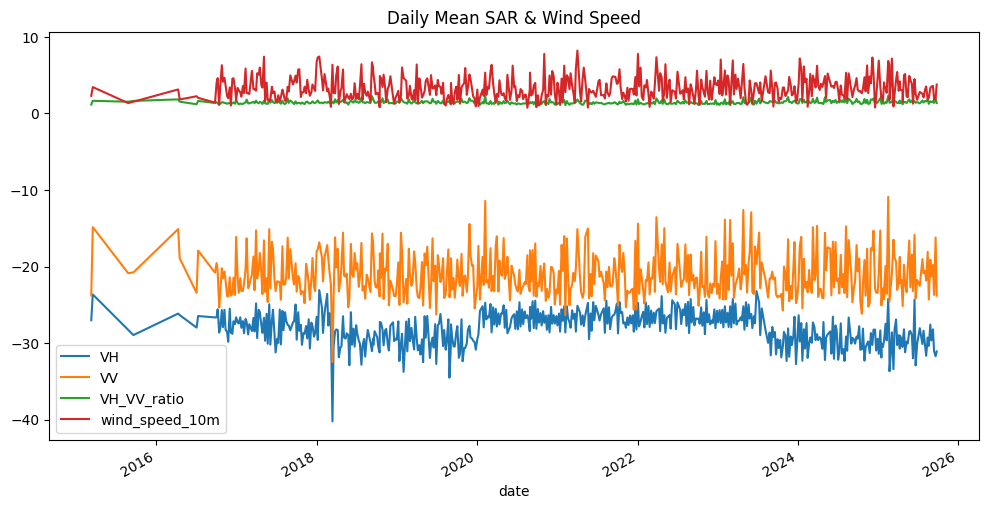

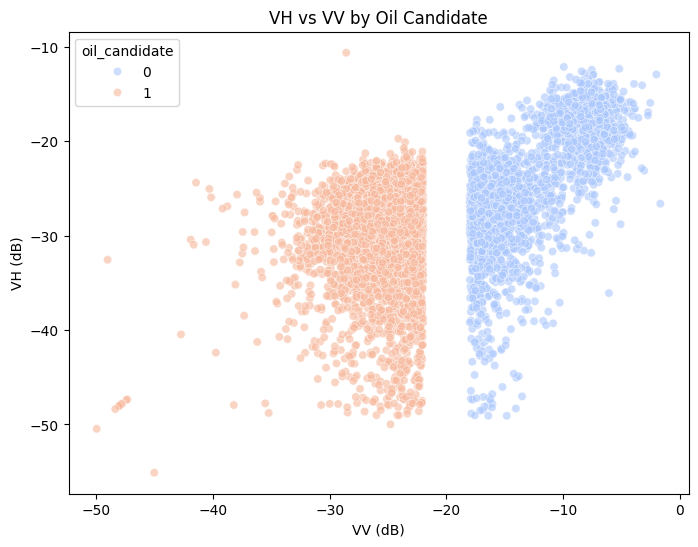

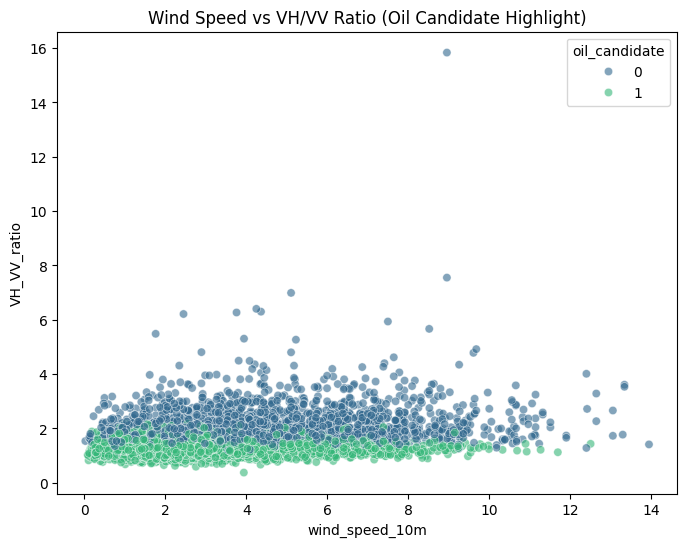

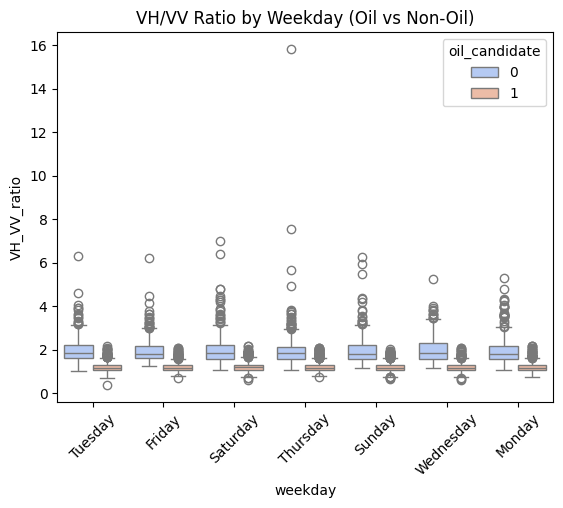

In [62]:
# Basic info
print(sar_data_2.info())
print(sar_data_2.describe())

# Quick correlation overview
plt.figure(figsize=(12,8))
sns.heatmap(sar_data_2.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

# Temporal trend: mean VH/VV per day
sar_data_2['date'] = pd.to_datetime(sar_data_2['date'])
daily = sar_data_2.groupby('date')[['VH', 'VV', 'VH_VV_ratio', 'wind_speed_10m']].mean()
daily.plot(figsize=(12,6), title='Daily Mean SAR & Wind Speed')
plt.show()

# VH vs VV (color by oil_candidate)
plt.figure(figsize=(8,6))
sns.scatterplot(data=sar_data_2, x='VV', y='VH', hue='oil_candidate', alpha=0.6, palette='coolwarm')
plt.title('VH vs VV by Oil Candidate')
plt.xlabel('VV (dB)')
plt.ylabel('VH (dB)')
plt.show()

# Wind Speed vs VH_VV_ratio (color by oil_candidate)
plt.figure(figsize=(8,6))
sns.scatterplot(data=sar_data_2, x='wind_speed_10m', y='VH_VV_ratio', hue='oil_candidate', alpha=0.6, palette='viridis')
plt.title('Wind Speed vs VH/VV Ratio (Oil Candidate Highlight)')
plt.show()

# Temporal insights: weekday/weekend
sar_data_2['weekday'] = sar_data_2['date'].dt.day_name()
sns.boxplot(data=sar_data_2, x='weekday', y='VH_VV_ratio', hue='oil_candidate', palette='coolwarm')
plt.title('VH/VV Ratio by Weekday (Oil vs Non-Oil)')
plt.xticks(rotation=45)
plt.show()

In [63]:

corr_columns = sar_data.select_dtypes(include=np.number)

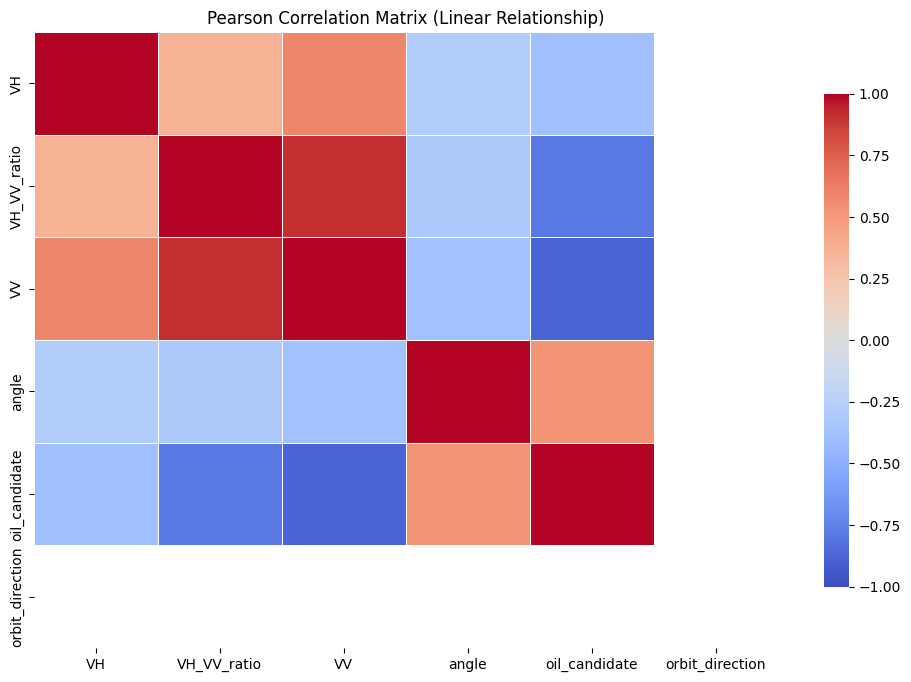

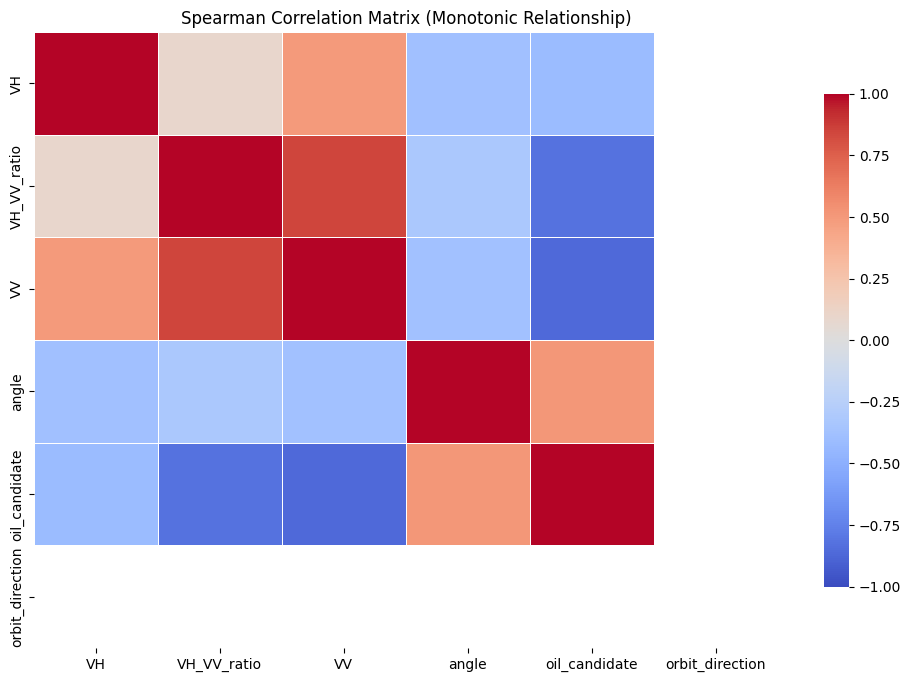

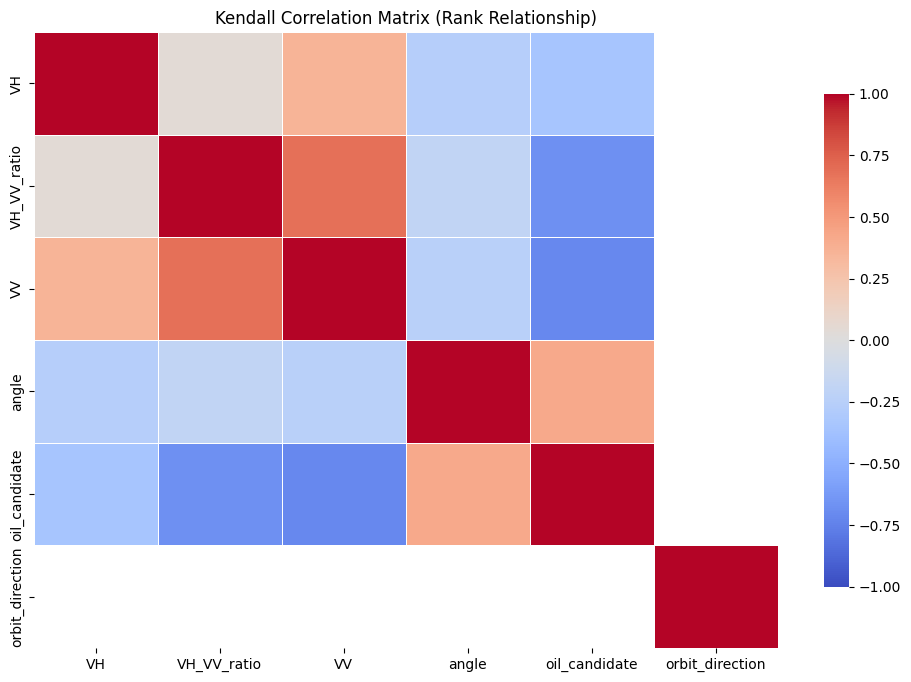

In [64]:
# Pearson, Spearman and Kendall Correlation Matrix

pearson_corr_matrix = corr_columns.corr(method="pearson")
spearman_corr_matrix = corr_columns.corr(method="spearman")
kendall_corr_matrix = corr_columns.corr(method="kendall")

# Function to plot
def plot_corr_heatmap(corr_matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        annot=False,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1,
    )
    plt.title(title)
    plt.show()

# Plot all three
plot_corr_heatmap(pearson_corr_matrix, "Pearson Correlation Matrix (Linear Relationship)")
plot_corr_heatmap(spearman_corr_matrix, "Spearman Correlation Matrix (Monotonic Relationship)")
plot_corr_heatmap(kendall_corr_matrix, "Kendall Correlation Matrix (Rank Relationship)")


In [65]:
# --- AI-GENERATED ---

# Merge NASA POWER data with SAR dataset

# Reset index of nasa_power and rename the index column to 'date'
nasa_power_reset = nasa_power.reset_index()
nasa_power_reset = nasa_power_reset.rename(columns={'index': 'date'})


# Convert the 'date' column to datetime in both dataframes
sar_data_2['date'] = pd.to_datetime(sar_data_2['date'])
nasa_power_reset['date'] = pd.to_datetime(nasa_power_reset['date'])

# Merge on date
sar_merged = pd.merge(sar_data_2, nasa_power_reset, on="date", how="left")

# Check merged result
print("Merged shape:", sar_merged.shape)
sar_merged.head()

# ------

Merged shape: (9381, 31)


,system:index,VH,VH_VV_ratio,VV,angle,date,dewpoint_temperature_2m,latitude,longitude,oil_candidate,...,weekday,T2M,PRECTOTCORR,T2M_z,PRECTOTCORR_z,T2M_rolling,PRECTOTCORR_rolling,cluster,temp_band,rolling_corr
0,0_1_33,-55.104848,1.223977,-45.021158,45.592400,2015-03-10,273.944037,39.368536,-76.010592,1,...,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0_1_139,-28.629801,1.050769,-27.246532,44.504768,2015-03-10,274.696804,39.033275,-76.188480,1,...,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0_1_239,-29.586230,1.173392,-25.214267,44.567307,2015-03-10,278.583035,37.959352,-75.946199,1,...,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0_1_250,-27.102570,1.093680,-24.781089,45.115185,2015-03-10,278.489203,37.712585,-75.779616,1,...,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0_1_290,-27.075435,1.123007,-24.109770,43.942677,2015-03-10,276.368272,38.733922,-76.248427,1,...,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


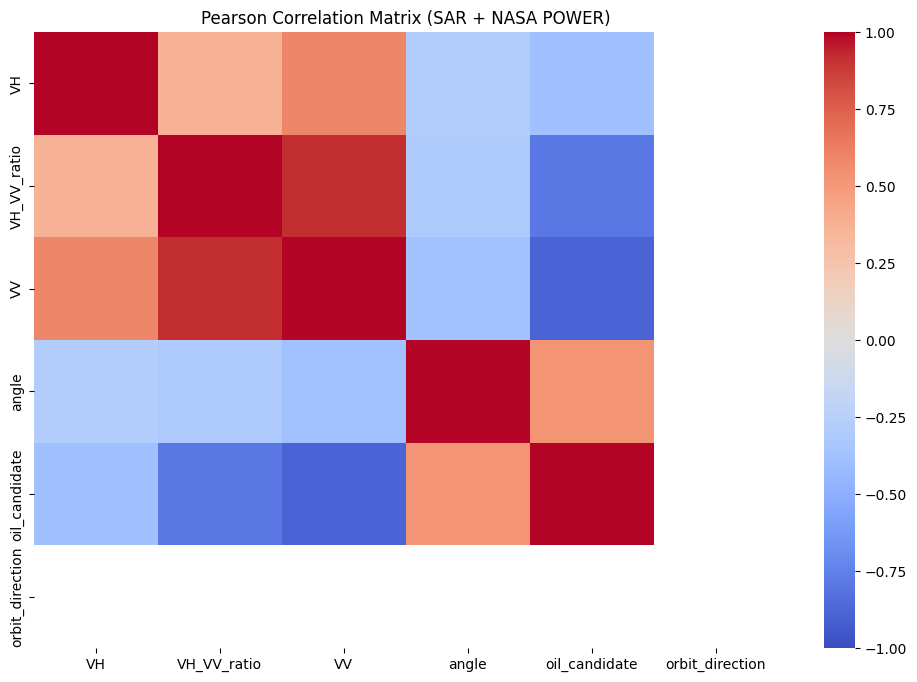

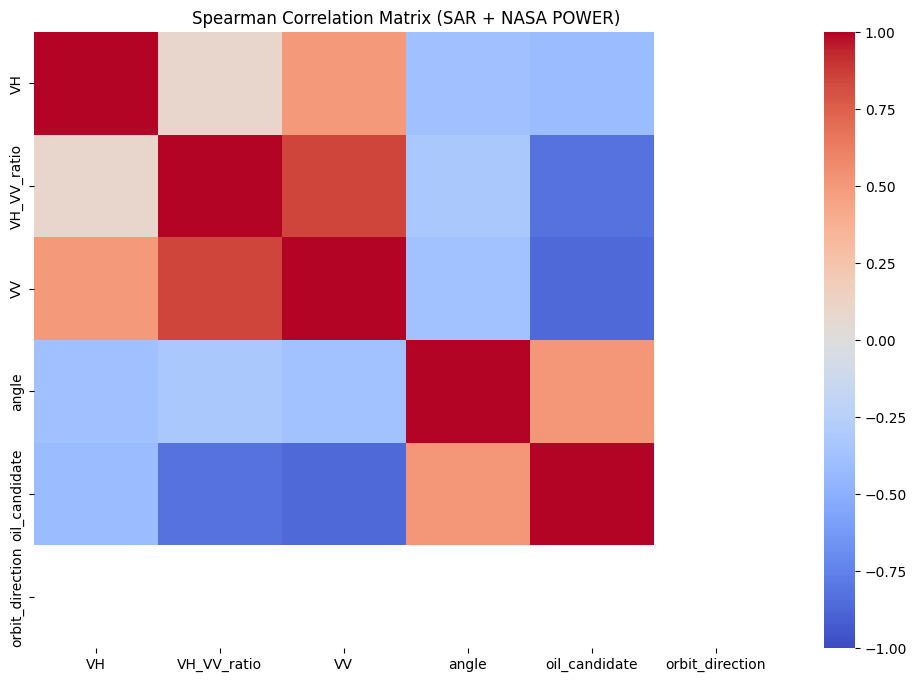

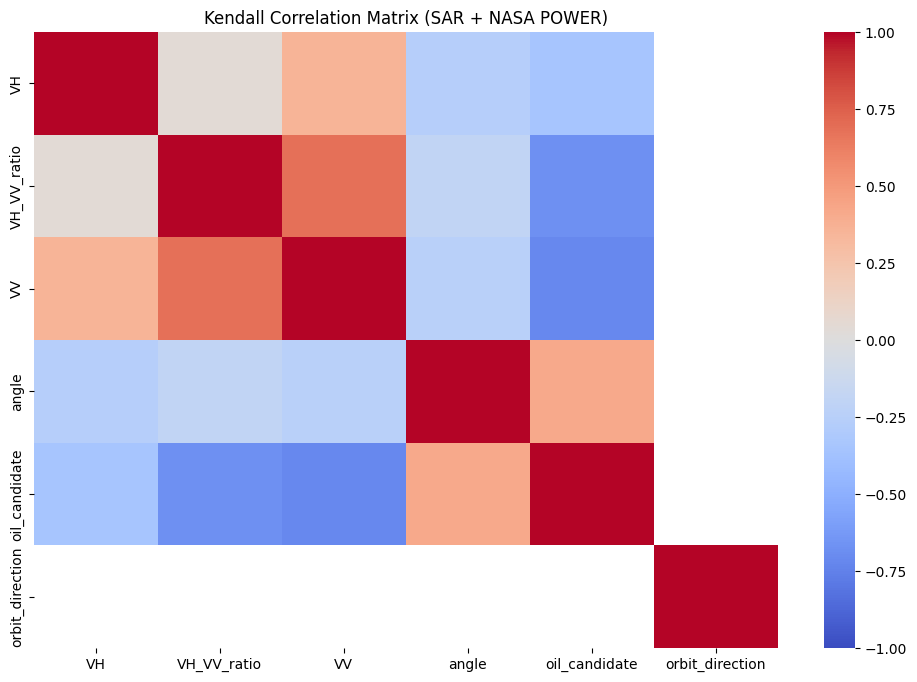

In [66]:

# Select only numeric columns

pearson_corr = corr_columns.corr(method="pearson")
spearman_corr = corr_columns.corr(method="spearman")
kendall_corr = corr_columns.corr(method="kendall")

# Plot all
for name, matrix in zip(
    ["Pearson", "Spearman", "Kendall"],
    [pearson_corr, spearman_corr, kendall_corr]
):
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"{name} Correlation Matrix (SAR + NASA POWER)")
    plt.show()


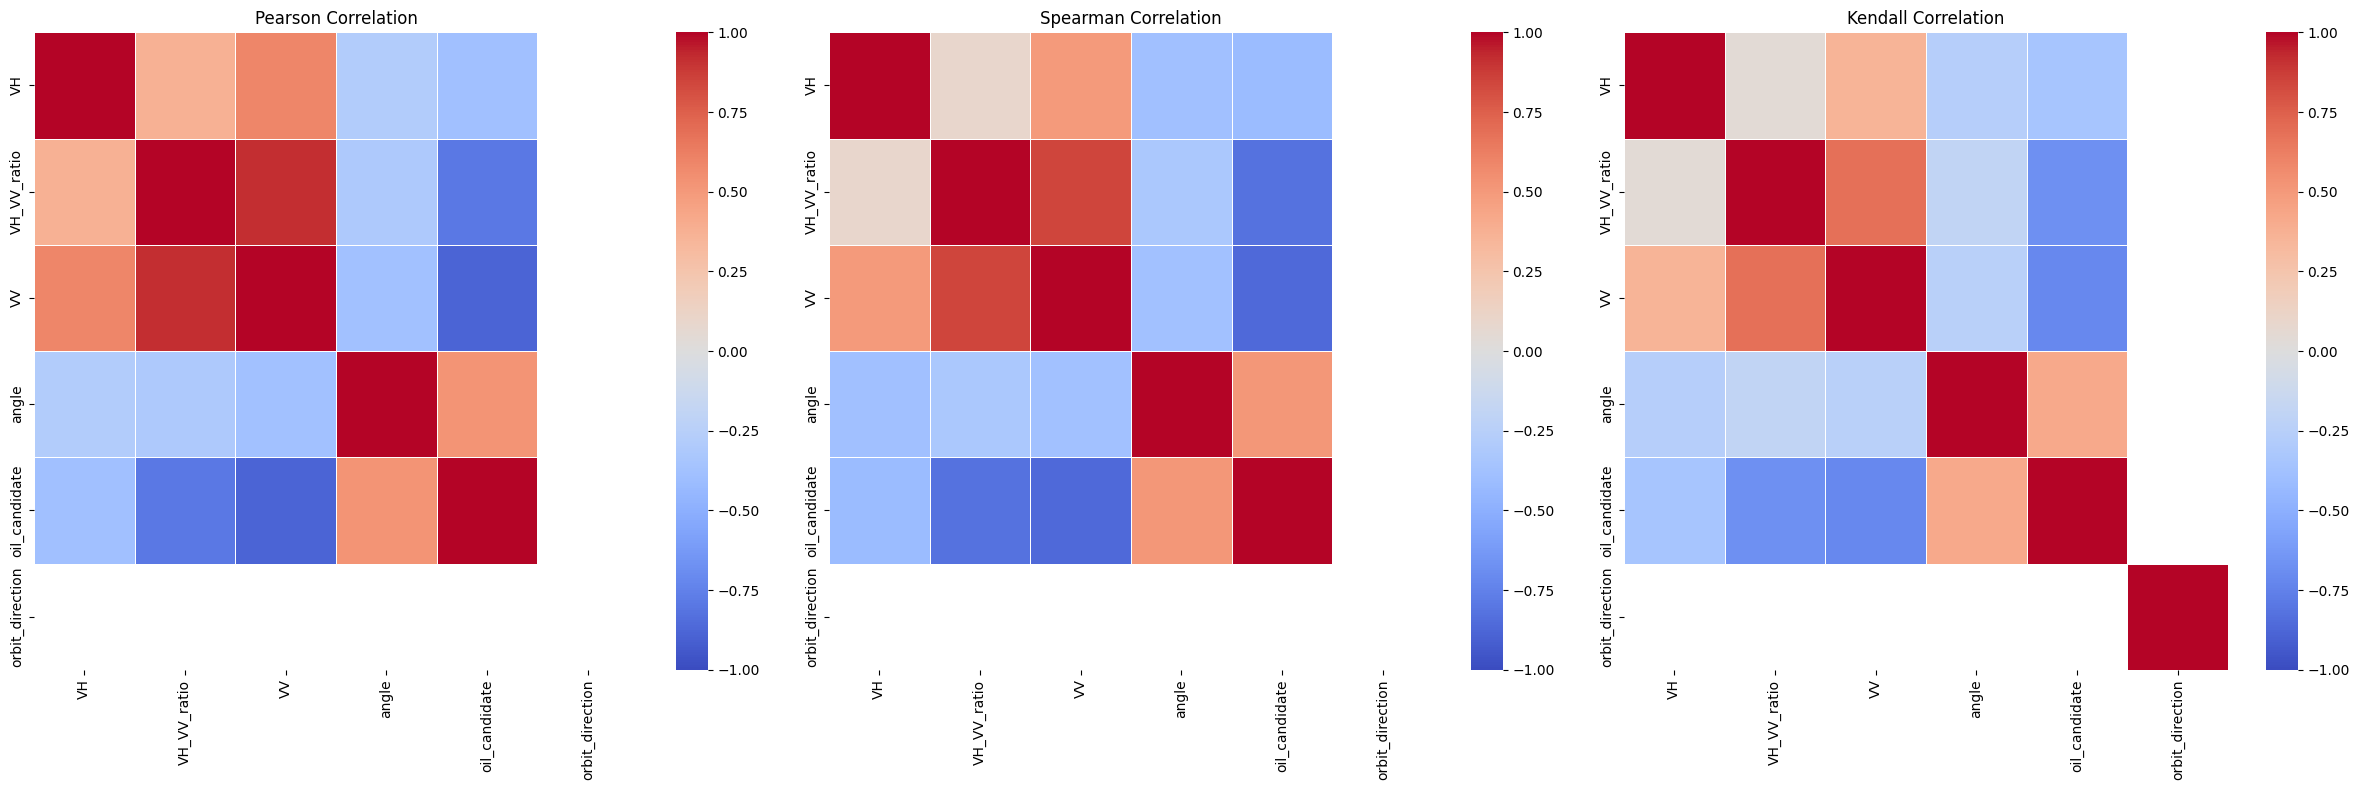

In [67]:
# Calculate correlation matrices
pearson_corr_matrix = corr_columns.corr(method="pearson")
spearman_corr_matrix = corr_columns.corr(method="spearman")
kendall_corr_matrix = corr_columns.corr(method="kendall")

# Plotting all three correlation heatmaps together
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.heatmap(
    pearson_corr_matrix, ax=axes[0],
    cmap="coolwarm", annot=False, linewidths=0.5, vmin=-1, vmax=1
)
axes[0].set_title("Pearson Correlation")

sns.heatmap(
    spearman_corr_matrix, ax=axes[1],
    cmap="coolwarm", annot=False, linewidths=0.5, vmin=-1, vmax=1
)
axes[1].set_title("Spearman Correlation")

sns.heatmap(
    kendall_corr_matrix, ax=axes[2],
    cmap="coolwarm", annot=False, linewidths=0.5, vmin=-1, vmax=1
)
axes[2].set_title("Kendall Correlation")

plt.tight_layout()
plt.show()

In [68]:
# --- AI-GENERATED ---

# --- Top correlated features with wind speed ---
target = "wind_speed_10m"

# Drop non-numeric columns first
corr_columns = sar_merged.select_dtypes(include=np.number)

if target in corr_columns.columns:
    print(f"\n Top 5 Features Most Correlated with {target}\n")

    # Pearson correlation
    pearson_top5 = (
        corr_columns.corr(method="pearson")[target]
        .drop(target)
        .sort_values(ascending=False)
        .head(5)
    )
    print(" Pearson Correlation:")
    print(pearson_top5, "\n")

    # Spearman correlation
    spearman_top5 = (
        corr_columns.corr(method="spearman")[target]
        .drop(target)
        .sort_values(ascending=False)
        .head(5)
    )
    print(" Spearman Correlation:")
    print(spearman_top5, "\n")

    # Kendall correlation
    kendall_top5 = (
        corr_columns.corr(method="kendall")[target]
        .drop(target)
        .sort_values(ascending=False)
        .head(5)
    )
    print(" Kendall Correlation:")
    print(kendall_top5)
else:
    print(f"Column '{target}' not found in dataset!")

#------


 Top 5 Features Most Correlated with wind_speed_10m

 Pearson Correlation:
T2M_rolling            0.712066
PRECTOTCORR_rolling    0.611764
PRECTOTCORR            0.514018
PRECTOTCORR_z          0.514018
T2M_z                  0.506435
Name: wind_speed_10m, dtype: float64 

 Spearman Correlation:
T2M_rolling            0.739843
PRECTOTCORR_rolling    0.606879
PRECTOTCORR            0.582239
PRECTOTCORR_z          0.582239
T2M_z                  0.424125
Name: wind_speed_10m, dtype: float64 

 Kendall Correlation:
T2M_rolling            0.565358
PRECTOTCORR            0.455384
PRECTOTCORR_z          0.455384
PRECTOTCORR_rolling    0.424791
T2M_z                  0.349101
Name: wind_speed_10m, dtype: float64


# **SAR with NASA POWER API (`sar_power`)**
**Goal:**
- Detect and cluster oil spill candidates based on SAR backscatter values.
- Analyze environmental influences on oil detection and persistence.
- Perform buffer and temporal overlap analysis to see how oil spills move or persist across nearby locations over time.
- Correlate environmental variables with oil presence to find patterns or predictors.

In [69]:
# Importing the new dataset
from google.colab import drive
drive.mount('/content/drive')

file_id = '1d2Qhco6c8VfFju38iVJE9lLhyX4hzQKV'
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

sar_power = pd.read_csv(download_url)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
sar_power.head()

,system:index,vh,vh_vv_ratio,vv,angle,date,dewpoint_temperature_2m,latitude,longitude,oil_candidate,...,v_component_of_wind_10m,wind_direction_degrees,wind_speed_10m,.geo,nasa_power_air_temp_2m,nasa_power_max_air_temp_2m,nasa_power_min_air_temp_2m,nasa_power_wind_speed_2m_m/s,nasa_power_precipitation_mm,nasa_power_solar_radiation_MJm2day
0,0_1_33,-55.104848,1.223977,-45.021158,45.592400,2015-03-10,273.944037,39.368536,-76.010592,1,...,0.553357,-63.309665,1.231959,"{""type"":""Point"",""coordinates"":[-76.01059248597...",5.05,10.24,0.18,1.38,12.41,5.51
1,0_1_139,-28.629801,1.050769,-27.246532,44.504768,2015-03-10,274.696804,39.033275,-76.188480,1,...,1.582450,-43.674721,2.187905,"{""type"":""Point"",""coordinates"":[-76.18847968650...",5.32,9.89,0.52,2.11,8.79,5.51
2,0_1_239,-29.586230,1.173392,-25.214267,44.567307,2015-03-10,278.583035,37.959352,-75.946199,1,...,2.334810,-34.086427,2.819162,"{""type"":""Point"",""coordinates"":[-75.94619901488...",5.64,9.45,2.95,1.89,1.52,6.78
3,0_1_250,-27.102570,1.093680,-24.781089,45.115185,2015-03-10,278.489203,37.712585,-75.779616,1,...,2.814994,-28.147147,3.192548,"{""type"":""Point"",""coordinates"":[-75.77961592134...",6.45,9.76,5.03,3.23,0.89,6.78
4,0_1_290,-27.075435,1.123007,-24.109770,43.942677,2015-03-10,276.368272,38.733922,-76.248427,1,...,1.830172,-37.400849,2.303825,"{""type"":""Point"",""coordinates"":[-76.24842717678...",5.35,8.64,1.58,1.99,4.30,4.77


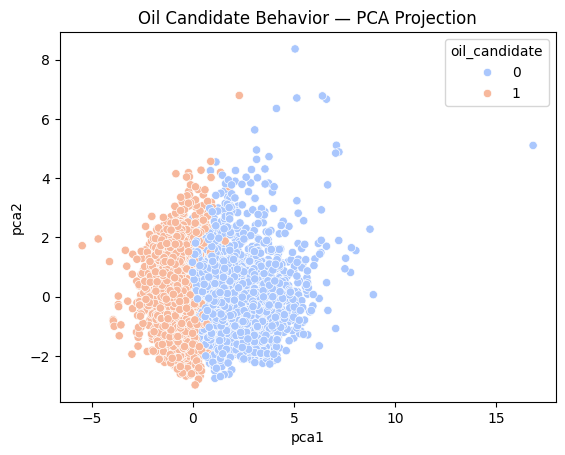

In [71]:
# Oil Candidate Behavior


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Selecting features for clustering
features = ['vh', 'vv', 'vh_vv_ratio', 'angle',
             'nasa_power_air_temp_2m', 'nasa_power_precipitation_mm',
             'nasa_power_wind_speed_2m_m/s']

scaled = StandardScaler().fit_transform(sar_power[features].dropna())

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled)

sar_power['pca1'] = pca_data[:, 0]
sar_power['pca2'] = pca_data[:, 1]

sns.scatterplot(data=sar_power, x='pca1', y='pca2', hue='oil_candidate', palette='coolwarm')
plt.title('Oil Candidate Behavior — PCA Projection')
plt.show()

/tmp/ipython-input-3927504510.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sar_power, x='oil_candidate', y=col, palette='coolwarm')


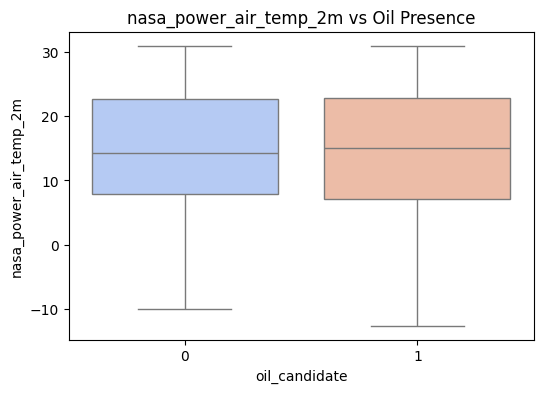

/tmp/ipython-input-3927504510.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sar_power, x='oil_candidate', y=col, palette='coolwarm')


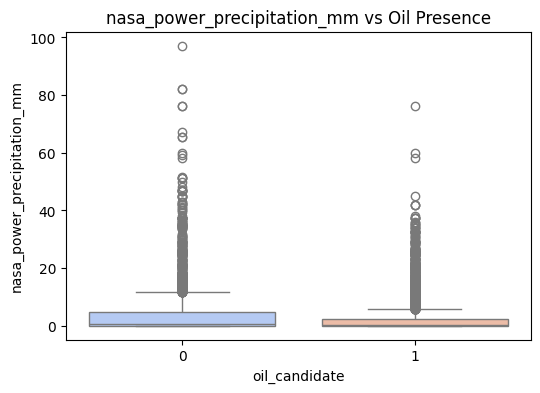

/tmp/ipython-input-3927504510.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sar_power, x='oil_candidate', y=col, palette='coolwarm')


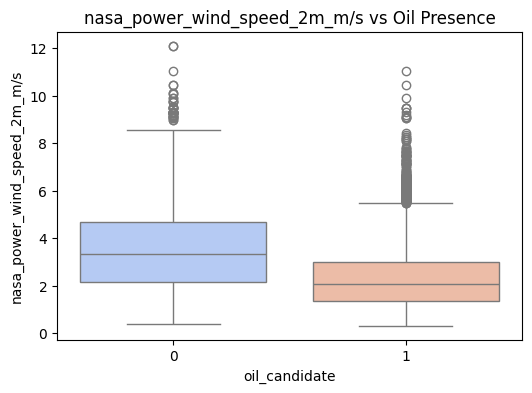

/tmp/ipython-input-3927504510.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sar_power, x='oil_candidate', y=col, palette='coolwarm')


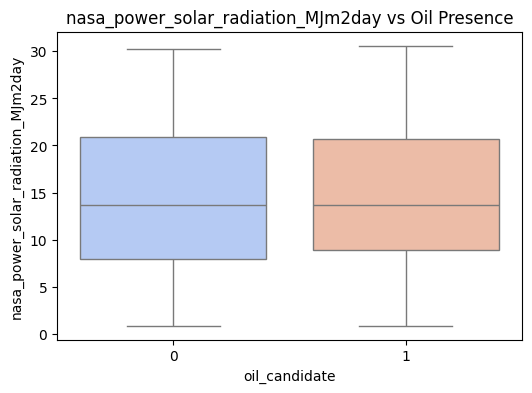

In [72]:
# Environmental Factors Influence

env_factors = ['nasa_power_air_temp_2m', 'nasa_power_precipitation_mm',
               'nasa_power_wind_speed_2m_m/s', 'nasa_power_solar_radiation_MJm2day']

for col in env_factors:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=sar_power, x='oil_candidate', y=col, palette='coolwarm')
    plt.title(f'{col} vs Oil Presence')
    plt.show()

In [73]:
# Spatio-Temporal Movement/Buffer Analysis

import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta

# Converting to GeoDataFrame
sar_gdf = gpd.GeoDataFrame(
    sar_power.copy(),
    geometry=gpd.points_from_xy(sar_power.longitude, sar_power.latitude),
    crs="EPSG:4326"
)

# Reprojecting to meters for distance/buffer calculations
sar_gdf = sar_gdf.to_crs(epsg=3857)

# Filtering only oil candidate locations
oil_gdf = sar_gdf[sar_gdf['oil_candidate'] == 1].copy()

# Converting date column to datetime format
oil_gdf['date'] = pd.to_datetime(oil_gdf['date'], errors='coerce')

# Creating 5 km buffer around each oil detection
oil_gdf['geometry_buffer'] = oil_gdf.geometry.buffer(5000)

# Sort by date (important for temporal comparison)
oil_gdf = oil_gdf.sort_values('date')

# --- AI-GENERATED ---
# Spatio-temporal overlap analysis
for date in sorted(oil_gdf['date'].dropna().unique())[:-1]:
    current_day = oil_gdf[oil_gdf['date'] == date]
    next_day = oil_gdf[oil_gdf['date'] == date + timedelta(days=1)]

    # Checking spatial overlap between current day and next day
    overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
    print(f"{date.date()}: {overlap} overlapping oil regions (within 5 km)")
# ------

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2015-03-10: 0 overlapping oil regions (within 5 km)
2015-03-17: 0 overlapping oil regions (within 5 km)
2015-08-25: 0 overlapping oil regions (within 5 km)
2015-09-18: 0 overlapping oil regions (within 5 km)
2016-04-09: 0 overlapping oil regions (within 5 km)
2016-04-16: 0 overlapping oil regions (within 5 km)
2016-07-02: 0 overlapping oil regions (within 5 km)
2016-07-09: 0 overlapping oil regions (within 5 km)
2016-09-24: 0 overlapping oil regions (within 5 km)
2016-10-01: 0 overlapping oil regions (within 5 km)
2016-10-06: 0 overlapping oil regions (within 5 km)
2016-10-13: 0 overlapping oil regions (within 5 km)
2016-10-18: 0 overlapping oil regions (within 5 km)
2016-10-25: 0 overlapping oil regions (within 5 km)
2016-10-30: 0 overlapping oil regions (within 5 km)
2016-11-06: 0 overlapping oil regions (within 5 km)
2016-11-11: 0 overlapping oil regions (within 5 km)
2016-11-18: 0 overlapping oil regions (within 5 km)
2016-11-23: 0 overlapping oil regions (within 5 km)
2016-11-30: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2017-11-01: 0 overlapping oil regions (within 5 km)
2017-11-06: 0 overlapping oil regions (within 5 km)
2017-11-13: 0 overlapping oil regions (within 5 km)
2017-11-18: 0 overlapping oil regions (within 5 km)
2017-11-25: 0 overlapping oil regions (within 5 km)
2017-11-30: 0 overlapping oil regions (within 5 km)
2017-12-07: 0 overlapping oil regions (within 5 km)
2017-12-12: 0 overlapping oil regions (within 5 km)
2017-12-19: 0 overlapping oil regions (within 5 km)
2017-12-24: 0 overlapping oil regions (within 5 km)
2017-12-31: 0 overlapping oil regions (within 5 km)
2018-01-05: 0 overlapping oil regions (within 5 km)
2018-01-12: 0 overlapping oil regions (within 5 km)
2018-01-24: 0 overlapping oil regions (within 5 km)
2018-01-29: 0 overlapping oil regions (within 5 km)
2018-02-05: 0 overlapping oil regions (within 5 km)
2018-02-17: 0 overlapping oil regions (within 5 km)
2018-02-22: 0 overlapping oil regions (within 5 km)
2018-03-01: 0 overlapping oil regions (within 5 km)
2018-03-06: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2019-12-14: 0 overlapping oil regions (within 5 km)
2019-12-21: 0 overlapping oil regions (within 5 km)
2019-12-26: 0 overlapping oil regions (within 5 km)
2020-01-02: 0 overlapping oil regions (within 5 km)
2020-01-07: 0 overlapping oil regions (within 5 km)
2020-01-14: 0 overlapping oil regions (within 5 km)
2020-01-26: 0 overlapping oil regions (within 5 km)
2020-01-31: 0 overlapping oil regions (within 5 km)
2020-02-12: 0 overlapping oil regions (within 5 km)
2020-02-19: 0 overlapping oil regions (within 5 km)
2020-02-24: 0 overlapping oil regions (within 5 km)
2020-03-02: 0 overlapping oil regions (within 5 km)
2020-03-07: 0 overlapping oil regions (within 5 km)
2020-03-14: 0 overlapping oil regions (within 5 km)
2020-03-19: 0 overlapping oil regions (within 5 km)
2020-03-26: 0 overlapping oil regions (within 5 km)
2020-03-31: 0 overlapping oil regions (within 5 km)
2020-04-07: 0 overlapping oil regions (within 5 km)
2020-04-12: 0 overlapping oil regions (within 5 km)
2020-04-19: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2021-01-20: 0 overlapping oil regions (within 5 km)
2021-01-25: 0 overlapping oil regions (within 5 km)
2021-02-01: 0 overlapping oil regions (within 5 km)
2021-02-06: 0 overlapping oil regions (within 5 km)
2021-02-13: 0 overlapping oil regions (within 5 km)
2021-02-18: 0 overlapping oil regions (within 5 km)
2021-02-25: 0 overlapping oil regions (within 5 km)
2021-03-02: 0 overlapping oil regions (within 5 km)
2021-03-09: 0 overlapping oil regions (within 5 km)
2021-03-14: 0 overlapping oil regions (within 5 km)
2021-03-21: 0 overlapping oil regions (within 5 km)
2021-03-26: 0 overlapping oil regions (within 5 km)
2021-04-02: 0 overlapping oil regions (within 5 km)
2021-04-14: 0 overlapping oil regions (within 5 km)
2021-04-19: 0 overlapping oil regions (within 5 km)
2021-04-26: 0 overlapping oil regions (within 5 km)
2021-05-01: 0 overlapping oil regions (within 5 km)
2021-05-08: 0 overlapping oil regions (within 5 km)
2021-05-20: 0 overlapping oil regions (within 5 km)
2021-05-25: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2022-01-20: 0 overlapping oil regions (within 5 km)
2022-01-27: 0 overlapping oil regions (within 5 km)
2022-02-01: 0 overlapping oil regions (within 5 km)
2022-02-08: 0 overlapping oil regions (within 5 km)
2022-02-13: 0 overlapping oil regions (within 5 km)
2022-02-20: 0 overlapping oil regions (within 5 km)
2022-02-25: 0 overlapping oil regions (within 5 km)
2022-03-04: 0 overlapping oil regions (within 5 km)
2022-03-09: 0 overlapping oil regions (within 5 km)
2022-03-16: 0 overlapping oil regions (within 5 km)
2022-03-21: 0 overlapping oil regions (within 5 km)
2022-04-09: 0 overlapping oil regions (within 5 km)
2022-04-14: 0 overlapping oil regions (within 5 km)
2022-04-21: 0 overlapping oil regions (within 5 km)
2022-04-26: 0 overlapping oil regions (within 5 km)
2022-05-03: 0 overlapping oil regions (within 5 km)
2022-05-08: 0 overlapping oil regions (within 5 km)
2022-05-15: 0 overlapping oil regions (within 5 km)
2022-05-20: 0 overlapping oil regions (within 5 km)
2022-05-27: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2023-03-16: 0 overlapping oil regions (within 5 km)
2023-03-23: 0 overlapping oil regions (within 5 km)
2023-03-28: 0 overlapping oil regions (within 5 km)
2023-04-04: 0 overlapping oil regions (within 5 km)
2023-04-09: 0 overlapping oil regions (within 5 km)
2023-04-16: 0 overlapping oil regions (within 5 km)
2023-04-21: 0 overlapping oil regions (within 5 km)
2023-05-03: 0 overlapping oil regions (within 5 km)
2023-05-10: 0 overlapping oil regions (within 5 km)
2023-05-15: 0 overlapping oil regions (within 5 km)
2023-05-22: 0 overlapping oil regions (within 5 km)
2023-05-27: 0 overlapping oil regions (within 5 km)
2023-06-08: 0 overlapping oil regions (within 5 km)
2023-06-15: 0 overlapping oil regions (within 5 km)
2023-06-20: 0 overlapping oil regions (within 5 km)
2023-06-27: 0 overlapping oil regions (within 5 km)
2023-07-09: 0 overlapping oil regions (within 5 km)
2023-07-14: 0 overlapping oil regions (within 5 km)
2023-07-21: 0 overlapping oil regions (within 5 km)
2023-08-07: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2024-06-02: 0 overlapping oil regions (within 5 km)
2024-06-09: 0 overlapping oil regions (within 5 km)
2024-06-14: 0 overlapping oil regions (within 5 km)
2024-06-21: 0 overlapping oil regions (within 5 km)
2024-06-26: 0 overlapping oil regions (within 5 km)
2024-07-03: 0 overlapping oil regions (within 5 km)
2024-07-08: 0 overlapping oil regions (within 5 km)
2024-07-15: 0 overlapping oil regions (within 5 km)
2024-07-20: 0 overlapping oil regions (within 5 km)
2024-07-27: 0 overlapping oil regions (within 5 km)
2024-08-01: 0 overlapping oil regions (within 5 km)
2024-08-08: 0 overlapping oil regions (within 5 km)
2024-08-13: 0 overlapping oil regions (within 5 km)
2024-08-20: 0 overlapping oil regions (within 5 km)
2024-09-01: 0 overlapping oil regions (within 5 km)
2024-09-06: 0 overlapping oil regions (within 5 km)
2024-09-13: 0 overlapping oil regions (within 5 km)
2024-09-18: 0 overlapping oil regions (within 5 km)
2024-09-25: 0 overlapping oil regions (within 5 km)
2024-09-30: 

/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

2025-05-28: 0 overlapping oil regions (within 5 km)
2025-06-04: 0 overlapping oil regions (within 5 km)
2025-06-09: 0 overlapping oil regions (within 5 km)
2025-06-16: 0 overlapping oil regions (within 5 km)
2025-06-21: 0 overlapping oil regions (within 5 km)
2025-06-28: 0 overlapping oil regions (within 5 km)
2025-07-10: 0 overlapping oil regions (within 5 km)
2025-07-22: 0 overlapping oil regions (within 5 km)
2025-07-27: 0 overlapping oil regions (within 5 km)
2025-08-03: 0 overlapping oil regions (within 5 km)
2025-08-08: 0 overlapping oil regions (within 5 km)
2025-08-15: 0 overlapping oil regions (within 5 km)
2025-08-20: 0 overlapping oil regions (within 5 km)
2025-08-27: 0 overlapping oil regions (within 5 km)
2025-09-01: 0 overlapping oil regions (within 5 km)
2025-09-08: 0 overlapping oil regions (within 5 km)
2025-09-13: 0 overlapping oil regions (within 5 km)
2025-09-20: 0 overlapping oil regions (within 5 km)


/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  overlap = current_day.geometry_buffer.intersects(next_day.unary_union).sum()
/tmp/ipython-input-2112888625.py:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method ins

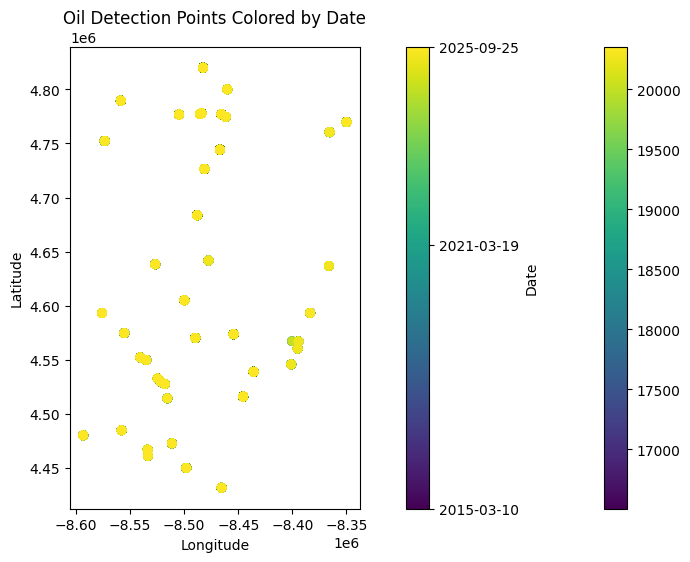

In [74]:
# Oil Detection Points

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


oil_gdf = oil_gdf.sort_values("date").copy()
oil_gdf["date_numeric"] = oil_gdf["date"].map(mdates.date2num)

fig, ax = plt.subplots(figsize=(15, 6))
oil_gdf.plot(column="date_numeric", cmap="viridis", legend=True, ax=ax)

plt.title("Oil Detection Points Colored by Date")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Fixing legend to show real dates
sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(vmin=oil_gdf["date_numeric"].min(), vmax=oil_gdf["date_numeric"].max())
)
sm._A = []
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Date")

date_ticks = mdates.num2date([
    oil_gdf["date_numeric"].min(),
    oil_gdf["date_numeric"].mean(),
    oil_gdf["date_numeric"].max()
])
cbar.set_ticks([oil_gdf["date_numeric"].min(), oil_gdf["date_numeric"].mean(), oil_gdf["date_numeric"].max()])
cbar.set_ticklabels([d.strftime("%Y-%m-%d") for d in date_ticks])

plt.show()
